In [83]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
        print("Setting GPU Memory Growth...")
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import time
import datetime

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from plot_keras_history import plot_history
import sklearn.metrics as metrics
import os as os

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dropout
from tensorflow.python.client import device_lib

import kerastuner as kt
from kerastuner.tuners import RandomSearch, BayesianOptimization


print("TF version:", tf.__version__)
print("KT version:", kt.__version__)
print("Panda version:", pd.__version__)

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print("Physical devices: ", tf.config.list_physical_devices())
# Se va a habilitar la dedicacion dinamica de memoria para que la GPU vaya asignando recursos al proceso conforme los vaya necesitando

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#print(tf.config.list_physical_devices('GPU'))
print("Build with CUDA: ", tf.test.is_built_with_cuda())

# Number of best models
numBestModels = 1 

# Validation set percentage
val_size = 0.3

# Batch size
batch = 1024

# Nodos internos
hidden_nodes = 10

# Units parameters
minUnits = 10
maxUnits = 50
stepsUnits = 10
defaultUnits = 30

# Dropout Parameters
minDropout = 0
maxDropout = 0.33
defaultDropout = .25

# Establecer medida de loss
loss = "mean_absolute_error"

# Learning rate
learningRate = [0.0, 1e-2, 1e-3, 1e-4]

# Model metrics
modelMetrics = [keras.metrics.MAE, tf.keras.metrics.RootMeanSquaredError(name = 'rmse')]

# Optimizer objetive: error percetange with the validation set 
objective = kt.Objective('val_mean_absolute_error', 'min')

# Maximum model trials and executions
trials = 40
executions = 2

# Epochs
epchs = 100

Setting GPU Memory Growth...


c:\Users\hecto\.conda\envs\myenv\lib\site-packages\tensorflow_core\python\client\session.py:1752: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


TF version: 2.1.0
KT version: 1.0.1
Panda version: 1.1.5
Physical devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Default GPU Device: /device:GPU:0
Num GPUs Available:  1
Build with CUDA:  True


In [84]:
df = pd.read_csv("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/training/2015_PV_W20_H20.csv",
                delimiter=";")

dfTest = pd.read_csv("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/test/2016_PV_W20_H20.csv",
                delimiter=";")

# X = pd.read_csv("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/training/2015_Weather_W7.csv",
#                        delimiter=",")

# xTest = pd.read_csv("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/test/2016_Weather_W7.csv",
#                    delimiter=",")

# projectNameBO = "Weather_W7-gru-bo"
# projectNameRS = "Weather_W7-gru-rs"

projectNameRS = "PV_W20_H20-gru-rs"
projectNameBO = "PV_W20_H20-gru-bo"

W=20
H=20

In [85]:
# # Old data preprocessing: each row will contain the 20 measures for each day , and the 10 measures for the following day
# # X = pd.DataFrame(np.array(training).reshape(-1, W))
# Y = pd.DataFrame.copy(X)
# yTest = pd.DataFrame.copy(xTest)

# Y.columns = ["col_{}".format(i) for i in range(W+1, (2*W)+1)]
# Y = Y.drop(0)
# Y = Y.reset_index(drop = True)
# Y.loc[len(Y)] = np.zeros(numPredictions)

# # Last row is deleted because it is the one used for the real prediction, 
# # it is not useful for the training of the model. 
# X.drop(X.tail(1).index, inplace = True)
# Y.drop(Y.tail(1).index, inplace = True)

# print("X Preproccessed shape: ", X.shape)
# print("Y Preproccessed shape: ", Y.shape)
# print("---------------------------------------------")

# #  Uncomment in order to normalize data
# # Data Normalization
# # scaler = MinMaxScaler()
# # X = pd.DataFrame(scaler.fit_transform(X), columns=["col_{}".format(i) for i in range(1, 21)])
# # Y = pd.DataFrame(scaler.fit_transform(Y), columns=["col_{}".format(i) for i in range(21, 41)])


In [86]:
# Preprocessing for PV_W_H type files:

#  Uncomment in order to normalize data
# Data Normalization

df = df.replace(',', '.', regex=True)
dfTest = dfTest.replace(',', '.', regex=True)

scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df))
dfTest = pd.DataFrame(scaler.fit_transform(dfTest))

# Filter for PV data
X = df.iloc[:, 0:W]
xTest = dfTest.iloc[:, 0:W]

Y = df.iloc[:, W:]
yTest = dfTest.iloc[:, W:]

numPredictions = H

print(X)
print(yTest)

In [87]:
# W type data preprocessing:

# Y will be the next day pv data, aka the last column from the next row.
shifted_df = X.shift(-1)
Y = pd.DataFrame(shifted_df.iloc[:, -1])

shifted_df = xTest.shift(-1)
yTest = pd.DataFrame(shifted_df.iloc[:, -1])

X.drop(X.tail(1).index, inplace = True)
Y.drop(Y.tail(1).index, inplace = True)

xTest.drop(xTest.tail(1).index, inplace = True)
yTest.drop(yTest.tail(1).index, inplace = True)

numPredictions = 1

print("X Preproccessed shape: ", X.shape)
print("Y Preproccessed shape: ", Y.shape)
print("---------------------------------------------")

print("X: ", X)
print("Y: ", Y)

X Preproccessed shape:  (358, 98)
Y Preproccessed shape:  (358, 1)
---------------------------------------------
X:       min_temp_d1  max_temp_d1  rainfall_d1  sun_hours_d1  max_wind_speed_d1  \
0       0.919431     0.699029     0.001095      0.774436           0.261538   
1       0.909953     0.621359     0.006572      0.315789           0.369231   
2       0.744076     0.684466     0.092004      0.902256           0.230769   
3       0.777251     0.582524     0.000000      0.285714           0.138462   
4       0.763033     0.650485     0.118291      0.909774           0.338462   
..           ...          ...          ...           ...                ...   
353     0.781991     0.733010     0.000000      0.864662           0.230769   
354     0.767773     0.699029     0.000000      0.721805           0.200000   
355     0.729858     0.703883     0.000000      0.902256           0.261538   
356     0.729858     0.582524     0.017525      0.097744           0.261538   
357     0.6777

In [88]:
dfPreproccessed = pd.concat([X, Y], axis = 1)

print("DataFrame Preproccessed:")
print(dfPreproccessed)
print("---------------------------------------------")

# Split the data into training and validation sets
xTrain, xVal, yTrain, yVal = train_test_split(X, 
                                            Y, 
                                            test_size = val_size, 
                                            random_state = 0, 
                                            shuffle=False)

# Adding the third dimension needed to use LSTM (samples, timestamps, features)
xtrain = np.reshape(xTrain.values, (xTrain.shape[0], 1, xTrain.shape[1]))
ytrain = np.reshape(yTrain.values, (yTrain.shape[0], 1, yTrain.shape[1]))
xval = np.reshape(xVal.values, (xVal.shape[0], 1,  xVal.shape[1]))
yval = np.reshape(yVal.values, (yVal.shape[0], 1, yVal.shape[1]))
xtest = np.reshape(xTest.values, (xTest.shape[0], 1, xTest.shape[1]))
ytest = np.reshape(yTest.values, (yTest.shape[0], 1, yTest.shape[1]))

# New shapes after third dimension added
print("Dimensions afther third dimension added:")
print("xTrain:\t"+str(xtrain.shape))
print("yTrain:\t"+str(ytrain.shape))
print("xVal:\t"+str(xval.shape))
print("yVal:\t"+str(yval.shape))
print("xTest:\t"+str(xtest.shape))
print("yTest:\t"+str(ytest.shape))

DataFrame Preproccessed:
     min_temp_d1  max_temp_d1  rainfall_d1  sun_hours_d1  max_wind_speed_d1  \
0       0.919431     0.699029     0.001095      0.774436           0.261538   
1       0.909953     0.621359     0.006572      0.315789           0.369231   
2       0.744076     0.684466     0.092004      0.902256           0.230769   
3       0.777251     0.582524     0.000000      0.285714           0.138462   
4       0.763033     0.650485     0.118291      0.909774           0.338462   
..           ...          ...          ...           ...                ...   
353     0.781991     0.733010     0.000000      0.864662           0.230769   
354     0.767773     0.699029     0.000000      0.721805           0.200000   
355     0.729858     0.703883     0.000000      0.902256           0.261538   
356     0.729858     0.582524     0.017525      0.097744           0.261538   
357     0.677725     0.597087     0.050383      0.774436           0.230769   

     temp_9_d1  Rel_hum_9_

In [89]:

# Model definition:
with tf.device('/gpu:0'): 
    
    def build_model(hp): 

        model = Sequential()
        
        # First layer: GRU. Number of units optimization
        model.add(GRU(units = hp.Int('units', 
                                    min_value = minUnits,
                                    max_value = maxUnits, 
                                    step = stepsUnits,
                                    default = defaultUnits),
                        return_sequences = False, 
                        input_shape = (xtrain.shape[1], xtrain.shape[2])))

        # Second layer: Dropout with percetange optimization
        model.add(
            Dropout(hp.Float('dropout', 
                            min_value = minDropout,
                            max_value = maxDropout,
                            default = defaultDropout)))
        
        # Last layer:
        model.add(Dense(numPredictions))

        print("Summary: ")
        model.summary()

        # # Set Epsilon to 1, in order to fix huge MAPE values.
        # keras.backend.set_epsilon(1)

        # Model compilation: learning rate optimization
        model.compile(loss = loss,
                    optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', 
                                                                values = learningRate)),
                    metrics = modelMetrics)

        return model

In [90]:
# Model training:
with tf.device('/gpu:0'): 
    # Create optimizer
    gruOptimizer = RandomSearch(build_model, 
                                objective = objective,
                                max_trials = trials, 
                                executions_per_trial = executions,
                                project_name = projectNameRS,
                                overwrite=True)
    
    gruOptimizer.search_space_summary()

    # Search execution with epochs
    initialTime = time.time()
    gruOptimizer.search(x = xtrain,
                        y = ytrain, 
                        epochs = epchs,
                        batch_size = batch,
                        validation_data = (xval, yval))
    finalTime = time.time()

    # Results summary
    gruOptimizer.results_summary()

    # Get best model generated
    model = gruOptimizer.get_best_models(num_models = numBestModels)[0]

    # Model training with epochs 
    history = model.fit(
                xtrain,
                ytrain,
                epochs = epchs,
                batch_size = batch,
                validation_data=(xval, yval))

    # Show model info
    print("Tiempo de entrenamiento (en segundos):\t"+str(finalTime - initialTime))
    # print("Tiempo de entrenamiento (en horas):\t"+str((finalTime - initialTime)/3600))
    print(history.history.keys())
    print(model.history.history)
    print(model.history.params)

Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 25)                9375      
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 26        
Total params: 9,401
Trainable params: 9,401
Non-trainable params: 0
_________________________________________________________________


Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 40)                16800     
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
Total params: 16,841
Trainable params: 16,841
Non-trainable params: 0
_________________________________________________________________
Train on 250 samples, validate on 108 samples
Epoch 1/1000
250/250 [==============================] - 1s 4ms/sample - loss: 0.3624 - mean_absolute_error: 0.3624 - rmse: 0.4276 - val_loss: 0.3467 - val_mean_absolute_error: 0.3467 - val_rmse: 0.3876
Epoch 2/1000
250/250 [==============================] - 0s 142us/sample - loss: 0.2356 - mean_absolute_error: 0.2356 - rmse:

Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 40)                16800     
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
Total params: 16,841
Trainable params: 16,841
Non-trainable params: 0
_________________________________________________________________
Train on 250 samples, validate on 108 samples
Epoch 1/1000
250/250 [==============================] - 1s 5ms/sample - loss: 0.5538 - mean_absolute_error: 0.5538 - rmse: 0.6140 - val_loss: 0.6601 - val_mean_absolute_error: 0.6601 - val_rmse: 0.6945
Epoch 2/1000
250/250 [==============================] - 0s 302us/sample - loss: 0.7630 - mean_absolute_error: 0.7630 - rmse:

INFO:tensorflow:Oracle triggered exit


Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 40)                16800     
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
Total params: 16,841
Trainable params: 16,841
Non-trainable params: 0
_________________________________________________________________
Train on 250 samples, validate on 108 samples
Epoch 1/1000
250/250 [==============================] - 1s 5ms/sample - loss: 0.0385 - mean_absolute_error: 0.0385 - rmse: 0.0519 - val_loss: 0.1017 - val_mean_absolute_error: 0.1017 - val_rmse: 0.1257
Epoch 2/1000
250/250 [==============================] - 0s 84us/sample - loss: 0.0406 - mean_absolute_error: 0.0406 - rmse: 

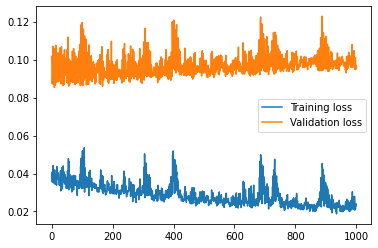

359/359 [==============================] - ETA: 0s - loss: 0.1127 - mean_absolute_error: 0.1127 - rmse: 0.13 - 0s 103us/sample - loss: 0.1149 - mean_absolute_error: 0.1149 - rmse: 0.1823
Score: [0.11485796064802531, 0.114857964, 0.18228416]


In [91]:
# Training and Validation loss curves
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

# Model evaluation with validation data
score = model.evaluate(xtest, ytest)
print('Score:', score)

In [92]:
# Model training:
with tf.device('/gpu:0'): 
    # Create optimizer
    gruOptimizer = BayesianOptimization(build_model, 
                                objective = objective,
                                max_trials = trials, 
                                executions_per_trial = executions,
                                project_name = projectNameBO,
                                overwrite=True)
    
    gruOptimizer.search_space_summary()

    # Search execution with epochs
    initialTime = time.time()
    gruOptimizer.search(x = xtrain,
                        y = ytrain, 
                        epochs = epchs,
                        batch_size = batch,
                        validation_data = (xval, yval))
    finalTime = time.time()

    # Results summary
    gruOptimizer.results_summary()

    # Get best model generated
    model = gruOptimizer.get_best_models(num_models = numBestModels)[0]

    # Model training with epochs 
    history = model.fit(
                xtrain,
                ytrain,
                epochs = epchs,
                batch_size = batch,
                validation_data=(xval, yval))

    # Show model info
    print("Tiempo de entrenamiento (en segundos):\t"+str(finalTime - initialTime))
    # print("Tiempo de entrenamiento (en horas):\t"+str((finalTime - initialTime)/3600))
    print(history.history.keys())
    print(model.history.history)
    print(model.history.params)

Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 25)                9375      
_________________________________________________________________
dropout (Dropout)            (None, 25)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 26        
Total params: 9,401
Trainable params: 9,401
Non-trainable params: 0
_________________________________________________________________


Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 40)                16800     
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
Total params: 16,841
Trainable params: 16,841
Non-trainable params: 0
_________________________________________________________________
Train on 250 samples, validate on 108 samples
Epoch 1/1000
250/250 [==============================] - 1s 4ms/sample - loss: 0.4033 - mean_absolute_error: 0.4033 - rmse: 0.4483 - val_loss: 0.5568 - val_mean_absolute_error: 0.5568 - val_rmse: 0.5926
Epoch 2/1000
250/250 [==============================] - 0s 182us/sample - loss: 0.3990 - mean_absolute_error: 0.3990 - rmse:

Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 40)                16800     
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
Total params: 16,841
Trainable params: 16,841
Non-trainable params: 0
_________________________________________________________________
Train on 250 samples, validate on 108 samples
Epoch 1/1000
250/250 [==============================] - 1s 5ms/sample - loss: 0.2367 - mean_absolute_error: 0.2367 - rmse: 0.2841 - val_loss: 0.3153 - val_mean_absolute_error: 0.3153 - val_rmse: 0.3487
Epoch 2/1000
250/250 [==============================] - 0s 82us/sample - loss: 0.2352 - mean_absolute_error: 0.2352 - rmse: 

INFO:tensorflow:Oracle triggered exit


Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 40)                16800     
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
Total params: 16,841
Trainable params: 16,841
Non-trainable params: 0
_________________________________________________________________
Train on 250 samples, validate on 108 samples
Epoch 1/1000
250/250 [==============================] - 1s 5ms/sample - loss: 0.0734 - mean_absolute_error: 0.0734 - rmse: 0.0962 - val_loss: 0.1237 - val_mean_absolute_error: 0.1237 - val_rmse: 0.1480
Epoch 2/1000
250/250 [==============================] - 0s 80us/sample - loss: 0.0660 - mean_absolute_error: 0.0660 - rmse: 

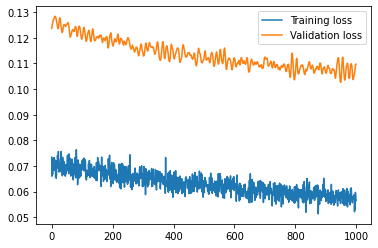

359/359 [==============================] - ETA: 0s - loss: 0.1541 - mean_absolute_error: 0.1541 - rmse: 0.17 - 0s 93us/sample - loss: 0.0919 - mean_absolute_error: 0.0919 - rmse: 0.1174
Score: [0.09190315452292769, 0.09190316, 0.11736301]


In [93]:
# Training and Validation loss curves
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

# Model evaluation with validation data
score = model.evaluate(xtest, ytest)
print('Score:', score)